In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial
from sklearn.linear_model import LinearRegression
import copy

In [2]:
def extract_region(data_array, regioncoords):
    """
    Extract a region from a DataArray with longitudes ranging from 0 to 360.
    Rearrange the data to have continuous longitudes even if the region wraps around 0 or 360 degrees.
    
    Parameters:
    data_array (xr.DataArray): Input DataArray with coordinates 'lon' (0 to 360) and 'lat'.
    min_lon (float): Minimum longitude of the region.
    max_lon (float): Maximum longitude of the region.
    min_lat (float): Minimum latitude of the region.
    max_lat (float): Maximum latitude of the region.
    
    Returns:
    xr.DataArray: Extracted region with continuous coordinates.
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords

    # Handle the case where the region crosses the prime meridian or the International Date Line
    if min_lon > max_lon:
        # Split the region into two parts: one on the left of 0° and one on the right
        region1 = data_array.sel(
            lon=slice(min_lon, 360), 
            lat=slice(min_lat, max_lat)
        )
        region2 = data_array.sel(
            lon=slice(0, max_lon), 
            lat=slice(min_lat, max_lat)
        )

        # Combine the two parts along the longitude axis
        combined_region = xr.concat([region1, region2], dim='lon')

    else:
        # Directly slice the region
        combined_region = data_array.sel(
            lon=slice(min_lon, max_lon), 
            lat=slice(min_lat, max_lat)
        )

    # # Sort the longitudes to ensure they are in the correct order
    # combined_region = combined_region.sortby('lon')

    return combined_region

# LENS2

In [3]:
path_pi_anoms = f'/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_pi/anoms_standardized.nc'
path_4xCO2_anoms = f'/glade/derecho/scratch/jhayron/Data4WRsClimateChange/CESM2_4xCO2/anoms_standardized.nc'

In [5]:
### pre-industrial
anoms = xr.open_dataset(path_pi_anoms)
# anoms = anoms
region = [180, 330, 20, 80]
data_region = extract_region(anoms, region).sel(time=slice(None, '2100-12-31'))
data_region = data_region.sel(time=data_region['time'].dt.month.isin([12, 1, 2, 3, 4, 5]))

composite_pi = data_region.mean('time')

In [38]:
### 4xCO2
anoms = xr.open_dataset(path_4xCO2_anoms)
# anoms = anoms
region = [180, 330, 20, 80]
data_region = extract_region(anoms, region)#.sel(time=slice(None, '2100-12-31'))
data_region = data_region.sel(time=data_region['time'].dt.month.isin([12, 1, 2, 3, 4, 5]))

composite_4xCO2 = data_region.mean('time')

In [39]:
diff = composite_4xCO2 - composite_pi

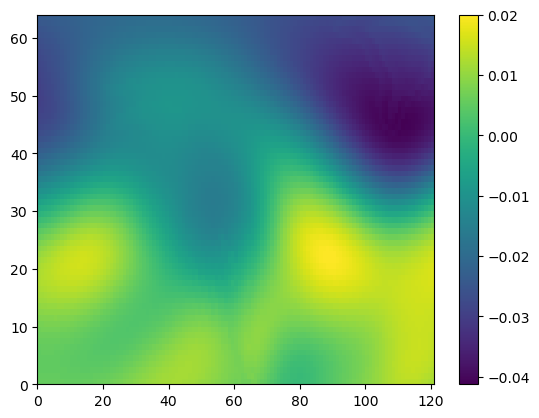

In [44]:
plt.pcolormesh(diff.Z_anom)
plt.colorbar()

In [ ]:
### 4xCO2
anoms = xr.open_dataset(path_pi_anoms)
# anoms = anoms
region = [180, 330, 20, 80]
data_region = extract_region(anoms, region).sel(time=slice(None, '2100-12-31'))
data_region = data_region.sel(time=data_region['time'].dt.month.isin([12, 1, 2, 3, 4, 5]))

composite_ = data_region.mean('time')

In [5]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS2_full_Z500_Anoms/'
files = np.sort(glob.glob(f'{path_anoms}*'))

In [19]:
diffs = []
for id_exp in range(len(files)):
    anoms = xr.open_dataset(files[id_exp])
    # anoms = anoms
    region = [180, 330, 20, 80]
    data_region = extract_region(anoms, region).sel(time=slice(None, '2100-12-31'))
    data_region = data_region.sel(time=data_region['time'].dt.month.isin([12, 1, 2, 3, 4, 5]))
    
    composite_future = data_region.sel(time=slice('2071-01-01','2100-12-31')).mean('time')
    composite_present = data_region.sel(time=slice('1994-01-01','2023-12-31')).mean('time')
    
    diff = composite_future-composite_present
    diffs.append(diff)

In [20]:
diffs = xr.concat(diffs,dim='exp')

In [30]:
mean_diff = diffs.mean('exp')
std_diff = diffs.std('exp')

In [32]:
diffs.to_netcdf('diffs_z500_model/lens2_diffs_z500.nc')

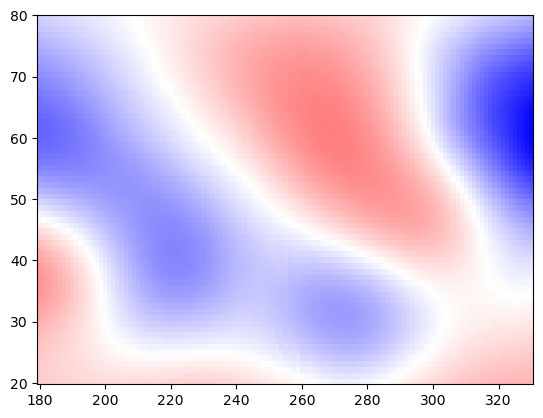

In [29]:
plt.pcolormesh(mean_diff.Z_anom.lon,mean_diff.Z_anom.lat,mean_diff.Z_anom,
               vmin=-0.5,vmax=0.5,cmap='bwr')

# E3SMv2

In [35]:
path_e3smv2_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/E3SMv2_le_Z500_Anoms/'

In [36]:
files = np.sort(glob.glob(f'{path_e3smv2_anoms}*'))

In [54]:
diffs = []
for id_exp in range(len(files)):
    anoms = xr.open_dataset(files[id_exp])
    # anoms = anoms
    region = [180, 330, 20, 80]
    data_region = extract_region(anoms, region).sel(time=slice(None, '2100-12-31'))
    if pd.to_datetime(data_region.time[-1].values).year==2100:
    # print(data_region.time[-1].valuespd.to_datetime(data_region.time[-1].values).year)
    # print(data_region.time[0].values)
    # print('****')
        data_region = data_region.sel(time=data_region['time'].dt.month.isin([12, 1, 2, 3, 4, 5]))
        
        composite_future = data_region.sel(time=slice('2071-01-01','2100-12-31')).mean('time')
        composite_present = data_region.sel(time=slice('1994-01-01','2023-12-31')).mean('time')
        
        diff = composite_future-composite_present
        diffs.append(diff)

In [55]:
len(diffs)

16

In [56]:
diffs = xr.concat(diffs,dim='exp')

In [57]:
mean_diff = diffs.mean('exp')
std_diff = diffs.std('exp')

In [58]:
diffs.to_netcdf('diffs_z500_model/e3smv2_diffs_z500.nc')

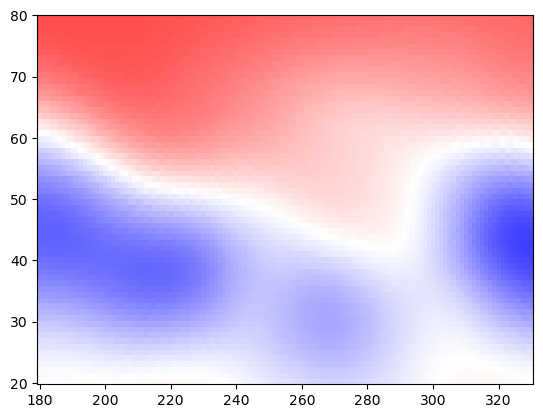

In [59]:
plt.pcolormesh(mean_diff.Z_anom.lon,mean_diff.Z_anom.lat,mean_diff.Z_anom,
               vmin=-0.5,vmax=0.5,cmap='bwr')